In [17]:
import sys
sys.path.append("..")

import os
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

from envs.trading_env import MyTradingEnv


INITIAL_BALANCE = 1000.0
WINDOW_SIZE = 10
COMMISSION = 0.0001
SLIPPAGE = 0.0005
MAX_HOLDING_TIME = 60 * 24
HOLDING_THRESHOLD = 24
MAX_DRAWDOWN_THRESHOLD = 0.05
LAMBDA_DRAWDOWN = 0.1
LAMBDA_HOLD = 0.028
REWARD_SCALING = 50.0

TRAIN_VERSION = "v1"

df1 = pd.read_csv("../data/data_1h_2021.csv", index_col=0, parse_dates=True)
df2 = pd.read_csv("../data/data_1h_2022.csv", index_col=0, parse_dates=True)
df3 = pd.read_csv("../data/data_1h_2023.csv", index_col=0, parse_dates=True)
df4 = pd.read_csv("../data/data_1h_2024.csv", index_col=0, parse_dates=True)

train_data = pd.concat([df2])

df_full = train_data.copy()


Q-Learning
------------------------------------------------------------
        Агент  Доходность %  Конечный баланс  Сделок  Win Rate %  Средний PnL  \
0  Q-Learning      0.107844      1001.078444       1       100.0     1.178444   

   Max Drawdown сделок %  Max Drawdown портфеля %  Sharpe Ratio  \
0               0.051303                 1.862296     -0.231702   

   Ср. время удержания  Закрыто по просадке  Закрыто по времени  
0                  2.0                    0                   0  


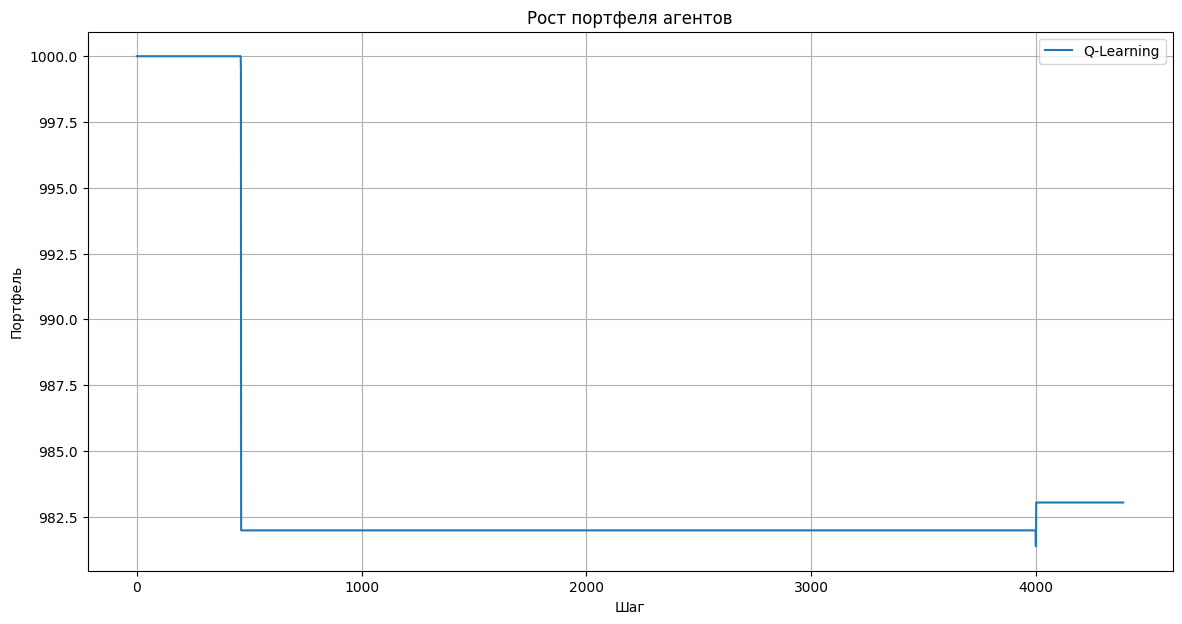

In [18]:
class QLearningLoaded:
    def __init__(self, data):
        self.q_table = data["q_table"]
        self.n_actions = data["n_actions"]
        self.epsilon = 0.0

    def select_action(self, state, training=False):
        key = tuple(state)

        q = self.q_table.get(key)
        if q is None:
            return 1
        return int(np.argmax(q))


class SARSALoaded:
    def __init__(self, data):
        self.q_table = data["q_table"]
        self.n_actions = data["n_actions"]
        self.epsilon = 0.0

    def select_action(self, state, training=False):
        key = tuple(state)
        q = self.q_table.get(key)
        if q is None:
            return 1
        return int(np.argmax(q))


class SARSALambdaLoaded:
    def __init__(self, data):
        self.q_table = data["q_table"]
        self.n_actions = data["n_actions"]
        self.lambda_param = data["lambda_param"]
        self.replace_traces = data["replace_traces"]
        self.epsilon = 0.0

    def select_action(self, state, training=False):
        key = tuple(state)
        q = self.q_table.get(key)
        if q is None:
            return 1
        return int(np.argmax(q))


class MonteCarloLoaded:
    def __init__(self, data):
        self.q_table = data.get("q_table", {})
        self.policy = data.get("policy", {})
        self.n_actions = data.get("n_actions", 3)

    def select_action(self, state, training=False):
        key = tuple(state)

        if key in self.policy:
            return int(np.argmax(self.policy[key]))

        if key in self.q_table:
            return int(np.argmax(self.q_table[key]))

        return 1 

# import numpy as np

# class QLearningLoaded:
#     def __init__(self, data, epsilon=0.0):
#         self.q_table = data["q_table"]
#         self.n_actions = data["n_actions"]
#         self.epsilon = epsilon

#     def select_action(self, state, training=False):
#         key = tuple(state)
#         if key not in self.q_table:
#             self.q_table[key] = np.zeros(self.n_actions)
        
#         if training and np.random.rand() < self.epsilon:
#             return np.random.randint(self.n_actions)
#         return int(np.argmax(self.q_table[key]))


# class SARSALoaded:
#     def __init__(self, data, epsilon=0.0):
#         self.q_table = data["q_table"]
#         self.n_actions = data["n_actions"]
#         self.epsilon = epsilon

#     def select_action(self, state, training=False):
#         key = tuple(state)
#         if key not in self.q_table:
#             self.q_table[key] = np.zeros(self.n_actions)
        
#         if training and np.random.rand() < self.epsilon:
#             return np.random.randint(self.n_actions)
#         return int(np.argmax(self.q_table[key]))


# class SARSALambdaLoaded:
#     def __init__(self, data, epsilon=0.0):
#         self.q_table = data["q_table"]
#         self.n_actions = data["n_actions"]
#         self.lambda_param = data["lambda_param"]
#         self.replace_traces = data["replace_traces"]
#         self.epsilon = epsilon

#     def select_action(self, state, training=False):
#         key = tuple(state)
#         if key not in self.q_table:
#             self.q_table[key] = np.zeros(self.n_actions)
        
#         if training and np.random.rand() < self.epsilon:
#             return np.random.randint(self.n_actions)
#         return int(np.argmax(self.q_table[key]))


# class MonteCarloLoaded:
#     def __init__(self, data):
#         self.q_table = data.get("q_table", {})
#         self.policy = data.get("policy", {})
#         self.n_actions = data.get("n_actions", 3)

#     def select_action(self, state, training=False):
#         key = tuple(state)
#         if key in self.policy:
#             return int(np.argmax(self.policy[key]))
#         if key in self.q_table:
#             return int(np.argmax(self.q_table[key]))
#         return np.random.randint(self.n_actions)


def load_agent(path):
    with open(path, "rb") as f:
        data = pickle.load(f)

    name = data["name"].lower()

    if "lambda" in name:
        return SARSALambdaLoaded(data)
    if "sarsa" in name:
        return SARSALoaded(data)
    if "q" in name:
        return QLearningLoaded(data)
    if "monte" in name:
        return MonteCarloLoaded(data)

    raise ValueError(f"Неизвестный агент: {data['name']}")


class ConsistentAgentComparator:
    def run_episode(self, env, agent):
        state, info = env.reset()
        done = False

        while not done:
            action = agent.select_action(state, training=False)
            state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

        metrics = env.get_metrics()
        metrics["portfolio_value"] = metrics.get("portfolio_value", info.get("portfolio_value", INITIAL_BALANCE))
        return metrics

    def record_portfolio(self, env, agent):
        state, info = env.reset()
        done = False
        values = []

        while not done:
            action = agent.select_action(state, training=False)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            values.append(info.get("portfolio_value", INITIAL_BALANCE))
            state = next_state

        return np.array(values)

    def run(self):

        agent_paths = {
            "Q-Learning": f"../training_data/checkpoints/exp_qlearning_{TRAIN_VERSION}/final_agent.pkl"
            # "SARSA": f"../training_data/checkpoints/exp_sarsa_{TRAIN_VERSION}/final_agent.pkl",
            # "SARSA-λ": f"../training_data/checkpoints/exp_sarsa_lambda_{TRAIN_VERSION}/final_agent.pkl",
            # "Monte Carlo": f"../training_data/checkpoints/exp_monte_carlo_{TRAIN_VERSION}/final_agent.pkl",
        }

        df = df_full.copy()
        results = []
        portfolio_history = {}

        for name, path in agent_paths.items():
            print(f"\n{name}")
            print("-" * 60)

            if not Path(path).exists():
                print(f"Файл не найден: {path}")
                continue

            agent = load_agent(path)

            env = MyTradingEnv(
                df=df.copy(),
                initial_balance=INITIAL_BALANCE,
                window_size=WINDOW_SIZE,
                commission=COMMISSION,
                slippage=SLIPPAGE,
                max_holding_time=MAX_HOLDING_TIME,
                lambda_drawdown=LAMBDA_DRAWDOWN,
                lambda_hold=LAMBDA_HOLD,
                reward_scaling=REWARD_SCALING,
            )

            metrics = self.run_episode(env, agent)

            values = self.record_portfolio(env, agent)
            portfolio_history[name] = values

            peak = np.maximum.accumulate(values)
            dd = (peak - values) / peak
            max_dd = dd.max() if len(dd) else 0

            returns = np.diff(values) / values[:-1]
            sharpe = (
                np.mean(returns) / (np.std(returns) + 1e-8) * np.sqrt(252)
                if len(returns) > 1 else 0
            )

            final_value = metrics.get("portfolio_value", INITIAL_BALANCE)

            results.append({
                "Агент": name,
                "Доходность %": (final_value / INITIAL_BALANCE - 1) * 100,
                "Конечный баланс": final_value,
                "Сделок": metrics.get("total_trades", 0),
                "Win Rate %": metrics.get("win_rate", 0),
                "Средний PnL": metrics.get("avg_pnl", 0),
                "Max Drawdown сделок %": metrics.get("max_drawdown", 0) * 100,
                "Max Drawdown портфеля %": max_dd * 100,
                "Sharpe Ratio": sharpe,
                "Ср. время удержания": metrics.get("avg_holding_time", 0),
                "Закрыто по просадке": metrics.get("trades_closed_by_drawdown", 0),
                "Закрыто по времени": metrics.get("trades_closed_by_time", 0),
            })

        df_res = pd.DataFrame(results)
        print(df_res)

        df_res.to_csv("consistent_comparison_results.csv", index=False)

        plt.figure(figsize=(14, 7))
        for name, values in portfolio_history.items():
            plt.plot(values, label=name)

        plt.title("Рост портфеля агентов")
        plt.xlabel("Шаг")
        plt.ylabel("Портфель")
        plt.grid()
        plt.legend()
        plt.savefig("portfolio_growth.png")
        plt.show()

if __name__ == "__main__":
    comparator = ConsistentAgentComparator()
    comparator.run()